## Funcion

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math

def circulacion(path, dibujo=False):
    # Cargar datos del JSON
    with open(path, "r") as file:
        data = json.load(file)

    # Crear el grafo dirigido
    G = nx.DiGraph()

    # Parámetros generales
    capacity = data["rs_info"]["capacity"]
    max_rs = data["rs_info"]["max_rs"]
    stations = data["stations"]
    cost_per_unit = data["cost_per_unit"]

    # 1. Agregar nodos y arcos de tren al grafo
    for service_id, service in data["services"].items():
        stops = service["stops"]
        demand = service["demand"][0]

        # Crear nodos para los eventos con demanda positiva o negativa según el tipo
        departure_event = f"{service_id}_D"
        arrival_event = f"{service_id}_A"
        
        G.add_node(departure_event, station=stops[0]["station"], time=stops[0]["time"], demand=math.ceil(demand / capacity))
        G.add_node(arrival_event, station=stops[1]["station"], time=stops[1]["time"], demand=-math.ceil(demand / capacity))

        # Agregar arco de tren con demanda mínima y capacidad máxima
        G.add_edge(
            departure_event,
            arrival_event,
            lower=math.ceil(demand / capacity),  # Demanda mínima
            upper=max_rs,  # Máximo permitido por servicio
            cost=0,  # Sin costo en arcos de tren
            type='train',  # Tipo de arco: tren
            color='blue'  # Color verde para los arcos de traspaso
        )

    # 2. Agregar arcos de traspaso dentro de cada estación
    events_by_station = {station: [] for station in stations}
    for node, attributes in G.nodes(data=True):
        events_by_station[attributes["station"]].append((node, attributes["time"]))

    for station, events in events_by_station.items():
        # Ordenar eventos por tiempo dentro de la misma estación
        events.sort(key=lambda x: x[1])
        for i in range(len(events) - 1):
            G.add_edge(
                events[i][0],
                events[i + 1][0],
                lower=0,
                upper=float('inf'),  # Sin límite superior
                cost=0,  # Sin costo en arcos de traspaso
                type='transfer' , # Tipo de arco: traspaso
                color='red'  # Color verde para los arcos de traspaso
            )

    # 3. Agregar arcos de trasnoche con capacidad ajustada
    for station, events in events_by_station.items():
        if events:
            first_event = events[0][0]
            last_event = events[-1][0]
            
            G.add_edge(
                last_event,
                first_event,
                lower=0,
                upper=1e10,  # Capacidad de trasnoche
                cost=cost_per_unit[station],  # Costo de trasnoche por unidad
                type='overnight'  ,# Tipo de arco: trasnoche
                color='green'  # Color verde para los arcos de trasnoche
            )

    # 4. Resolver flujo mínimo y calcular costos
    flow_cost, flow_dict = nx.capacity_scaling(G, demand='demand', weight='cost')


    # 5. Mostrar resultados en texto
    print("Costo mínimo (vagones):", flow_cost)
    print("\nFlujo por arco:")
    for u, v, attributes in G.edges(data=True):
        flujo = flow_dict.get(u, {}).get(v, 0)
        print(f"{u} -> {v}: Flujo = {flujo}, Costo = {attributes['cost']}")

    if dibujo:

        # 6. Identificar estaciones recorridas y trasnoche para cada tren
        for service_id, service in data["services"].items():
            recorrido = []
            trasnoche_station = None

            stops = service["stops"]
            departure_event = f"{service_id}_D"
            arrival_event = f"{service_id}_A"
            
            # Rastrear estaciones recorridas basadas en el flujo
            for u, destinations in flow_dict.items():
                if u.startswith(service_id):
                    for v, flujo in destinations.items():
                        if flujo > 0 and G.nodes[u]['station'] not in recorrido:
                            recorrido.append(G.nodes[u]['station'])
                        if flujo > 0 and G.nodes[v]['station'] not in recorrido:
                            recorrido.append(G.nodes[v]['station'])



        # Dibujar circulación
        pos = {}
        for index, (node, attributes) in enumerate(G.nodes(data=True)):
            station_idx = stations.index(attributes["station"])
            pos[node] = (attributes["time"] + index * 10, station_idx)  # Añadir `index * 10` para desplazar los nodos horizontalmente

        # Dibujar nodos con un tamaño más grande y color claro
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.7)

        # Dibujar las etiquetas de los nodos
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

        # Dibujar aristas con diferentes estilos para evitar superposición
        edge_data = []  # Para almacenar los datos de las aristas y luego usarlos en la tabla
        for (u, v, attributes) in G.edges(data=True):
            color = attributes['color']
            flow_value = flow_dict.get(u, {}).get(v, 0)
            
            # Configurar el estilo de la conexión
            if color == 'green':
                connectionstyle = 'arc3,rad=0.2'  # Curva hacia arriba para rojo
            else:
                connectionstyle = 'arc3,rad=0'  # Línea recta para otros colores
            
            # Dibujar la arista
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u, v)], edge_color=color, width=2,
                arrowstyle="->", arrowsize=10, alpha=1, connectionstyle=connectionstyle
            )


        # Agregar título y etiquetas
        plt.title("Grafo de flujo de trenes ", fontsize=16)
        plt.xlabel("Tiempo (Unidades de Tiempo)", fontsize=12)
        plt.ylabel("Estación (Índice)", fontsize=12)

        # Mostrar el gráfico
        plt.show()



## Modelo

Costo mínimo (vagones): 15.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0
1_D -> 3_A: Flujo = 0, Costo = 0
1_A -> 2_A: Flujo = 5, Costo = 0
2_D -> 2_A: Flujo = 0, Costo = 0
2_D -> 4_A: Flujo = 0, Costo = 0
2_A -> 3_D: Flujo = 10, Costo = 1.0
3_D -> 3_A: Flujo = 0, Costo = 0
3_D -> 4_D: Flujo = 5, Costo = 0
3_A -> 2_D: Flujo = 5, Costo = 0
4_D -> 4_A: Flujo = 0, Costo = 0
4_D -> 1_A: Flujo = 0, Costo = 0
4_A -> 1_D: Flujo = 5, Costo = 1.0


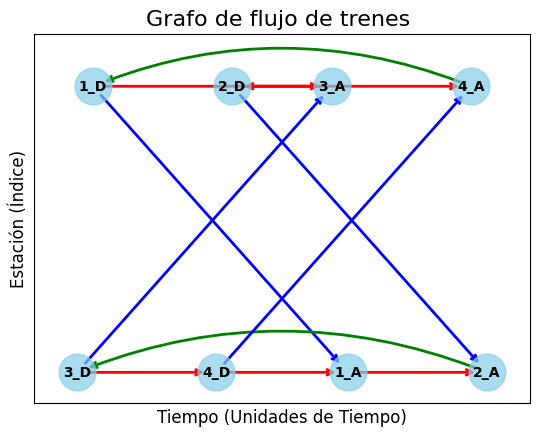

In [28]:
circulacion(r"..\instances\toy_instance.json", True)

## Experimentacion

### Demandas
Queriamos ver si cambiabamos la demanda cuanto cambiaba la cantidad de vagones necesarios y si la necesidad es lineal a la demanda

#### Demanda Baja:
Con demanda igual siempre en 100

In [29]:
path = r"..\instances\experimentacion\demandas\demanda_baja.json"
circulacion(path)

Costo mínimo (vagones): 2

Flujo por arco:
2001_D -> 2001_A: Flujo = 0, Costo = 0
2001_D -> 2002_A: Flujo = 1, Costo = 0
2001_A -> 2002_D: Flujo = 1, Costo = 0
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 0, Costo = 0
2002_A -> 2005_D: Flujo = 2, Costo = 0
2005_D -> 2005_A: Flujo = 0, Costo = 0
2005_D -> 2007_D: Flujo = 1, Costo = 0
2005_A -> 2006_D: Flujo = 1, Costo = 0
2006_D -> 2006_A: Flujo = 0, Costo = 0
2006_D -> 2007_A: Flujo = 0, Costo = 0
2006_A -> 2009_D: Flujo = 1, Costo = 0
2007_D -> 2007_A: Flujo = 0, Costo = 0
2007_D -> 2006_A: Flujo = 0, Costo = 0
2007_A -> 2008_D: Flujo = 1, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 1, Costo = 0
2009_D -> 2009_A: Flujo = 0, Costo = 0
2009_D -> 2008_A: Flujo = 0, Costo = 0
2009_A -> 2010_D: Flujo = 1, Costo = 0
2010_D -> 2010_A: Flujo = 0, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 1, Costo = 0
2011_D -> 2011_A: Flu

#### Demanda Alta:
Con demanda en todas las estaciones constante en 1000 

In [30]:
path = r"..\instances\experimentacion\demandas\demanda_alta.json"
circulacion(path)

Costo mínimo (vagones): 20

Flujo por arco:
2001_D -> 2001_A: Flujo = 9, Costo = 0
2001_D -> 2002_A: Flujo = 10, Costo = 0
2001_A -> 2002_D: Flujo = 10, Costo = 0
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 0, Costo = 0
2002_A -> 2005_D: Flujo = 20, Costo = 0
2005_D -> 2005_A: Flujo = 0, Costo = 0
2005_D -> 2007_D: Flujo = 10, Costo = 0
2005_A -> 2006_D: Flujo = 10, Costo = 0
2006_D -> 2006_A: Flujo = 0, Costo = 0
2006_D -> 2007_A: Flujo = 0, Costo = 0
2006_A -> 2009_D: Flujo = 10, Costo = 0
2007_D -> 2007_A: Flujo = 0, Costo = 0
2007_D -> 2006_A: Flujo = 0, Costo = 0
2007_A -> 2008_D: Flujo = 10, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 10, Costo = 0
2009_D -> 2009_A: Flujo = 0, Costo = 0
2009_D -> 2008_A: Flujo = 0, Costo = 0
2009_A -> 2010_D: Flujo = 10, Costo = 0
2010_D -> 2010_A: Flujo = 0, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 10, Costo = 0
2011_D -> 

In [33]:
path= r"..\instances\experimentacion\demandas\demanda_mixta.json"
circulacion(path)

Costo mínimo (vagones): 23

Flujo por arco:
2001_D -> 2001_A: Flujo = 7, Costo = 0
2001_D -> 2002_A: Flujo = 7, Costo = 0
2001_A -> 2002_D: Flujo = 16, Costo = 0
2002_D -> 2002_A: Flujo = 0, Costo = 0
2002_D -> 2005_A: Flujo = 10, Costo = 0
2002_A -> 2005_D: Flujo = 13, Costo = 0
2005_D -> 2005_A: Flujo = 0, Costo = 0
2005_D -> 2007_D: Flujo = 5, Costo = 0
2005_A -> 2006_D: Flujo = 18, Costo = 0
2006_D -> 2006_A: Flujo = 2, Costo = 0
2006_D -> 2007_A: Flujo = 7, Costo = 0
2006_A -> 2009_D: Flujo = 11, Costo = 0
2007_D -> 2007_A: Flujo = 0, Costo = 0
2007_D -> 2006_A: Flujo = 0, Costo = 0
2007_A -> 2008_D: Flujo = 12, Costo = 0
2008_D -> 2008_A: Flujo = 0, Costo = 0
2008_D -> 2009_A: Flujo = 0, Costo = 0
2008_A -> 2011_D: Flujo = 12, Costo = 0
2009_D -> 2009_A: Flujo = 1, Costo = 0
2009_D -> 2008_A: Flujo = 0, Costo = 0
2009_A -> 2010_D: Flujo = 11, Costo = 0
2010_D -> 2010_A: Flujo = 0, Costo = 0
2010_D -> 2011_A: Flujo = 0, Costo = 0
2010_A -> 2013_D: Flujo = 16, Costo = 0
2011_D -> 2